In [ ]:
    from torch import Tensor
    dataset1 = AMP_Dataset(esm_flag = True) # esm_flag = True
    dataset2 = AMP_Dataset_old(esm_flag = True) # esm_flag = True
    item1 = dataset1[0]
    item2 = dataset2[0]

    # Check keys are the same
    assert item1.keys() == item2.keys(), "Keys mismatch"

    # Check values
    for k in item1:
        v1, v2 = item1[k], item2[k]
        if isinstance(v1, Tensor) and isinstance(v2, Tensor):
            equal = torch.equal(v1, v2)
        else:
            equal = v1 == v2
        print(f"{k}: {'equal' if equal else 'different'}")
    
    print(item1["esm_states"].shape)
    print(item2["esm_states"].shape)

In [ ]:
# count no. of files in a list of directory
import os
folder_paths = ["/cluster/home/austinen/mini/ampmini/data/esmfold_train_features"]
file_counts = {}
for folder_path in folder_paths:
    file_counts[folder_path.split("/")[-1]] = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
for folder,count in file_counts.items():
    print(f"{folder}: {count}")


In [ ]:
# already checked successfully
# "./ampmini/data/s1_train_AMPseqs.csv"
# "./ampmini/data/s2_train_AMPseqs.csv"
# "./ampmini/data/s1_test_AMPseqs.csv"

import os
from Bio import SeqIO
import pandas as pd

# labels = ['antibacterial','antifungal','antiviral','anticancer','antigram-positive','antigram-negative',
#           'anti_mammalian_cells','antihiv','antimrsa','antiparasitic','antibiofilm',
#           'chemotactic','endotoxin','insecticidal']
# labels = ["cdhit_40"]
labels = ["s1"]

def get_filtered_fasta_paths(root_dir, labels, extensions=(".fasta", ".fa", ".fna")):
    """
    Returns paths to FASTA files under root_dir (recursively) that contain any of the given label keywords.
    """
    labels_lower = [label.lower() for label in labels]
    filtered_paths = []

    for dirpath, _, filenames in os.walk(root_dir):
        for filename in filenames:
            if filename.lower().endswith(extensions):
                if any(label in filename.lower() for label in labels_lower):
                    filtered_paths.append(os.path.join(dirpath, filename))

    return filtered_paths

def load_csv_sequences(csv_path, column_name="sequence"):
    """Load sequences from a CSV file into a set for fast lookup."""
    df = pd.read_csv(csv_path)
    return set(df[column_name].astype(str).str.strip())

def check_fasta_sequences_in_csv(fasta_paths, csv_sequences):
    """Check if all sequences in each FASTA file are in the CSV set."""
    results = {}
    for fasta_path in fasta_paths:
        missing_sequences = []
        for record in SeqIO.parse(fasta_path, "fasta"):
            seq = str(record.seq).strip()
            if seq not in csv_sequences:
                missing_sequences.append((record.id, seq))
        
        # Report
        if missing_sequences:
            print(f"\n❌ Missing sequences in {fasta_path}:")
            for rid, seq in missing_sequences:
                print(f"  - ID: {rid}")
        else:
            print(f"\n✅ All sequences from {fasta_path} are present in CSV.")
        
        results[fasta_path] = missing_sequences
    return results

# Example usage
fasta_files = get_filtered_fasta_paths("./ampmini/data/raw_data/AMP_s1/test",labels)
print(len(fasta_files), "FASTA files found.")
csv_path = "./ampmini/data/s1_test_AMPseqs.csv"
csv_column = "sequence"

csv_seq_set = load_csv_sequences(csv_path, csv_column)
missing_map = check_fasta_sequences_in_csv(fasta_files, csv_seq_set)

print("\n=== Summary ===")
for file, missing in missing_map.items():
    print(f"{os.path.basename(file)}: {'✅ All found' if not missing else f'❌ {len(missing)} missing'}")


In [ ]:
import pandas as pd

def load_sequences(csv_path, column_name="sequence"):
    """Load sequences from a CSV file into a set."""
    df = pd.read_csv(csv_path)
    return set(df[column_name].astype(str).str.strip())

def compare_sequence_sets(set1, set2):
    """Compute intersections and differences."""
    common = set1 & set2
    only_in_1 = set1 - set2
    only_in_2 = set2 - set1
    return common, only_in_1, only_in_2

# Paths and column name
csv1_path = "./ampmini/data/s1_test_AMPseqs.csv"
csv2_path = "./ampmini/data/s2_test_AMPseqs.csv"
column_name = "sequence"  # adjust if your column is named differently

# Load
seqs1 = load_sequences(csv1_path, column_name)
seqs2 = load_sequences(csv2_path, column_name)

# Compare
common, unique1, unique2 = compare_sequence_sets(seqs1, seqs2)

# Print results
print(f"✅ Common sequences: {len(common)}")
print(f"🔹 Unique to {csv1_path}: {len(unique1)}")
print(f"🔸 Unique to {csv2_path}: {len(unique2)}")

# Optional: print actual sequences
# print("\nUnique to CSV1:\n", unique1)
# print("\nUnique to CSV2:\n", unique2)

# ✅ Common sequences: 1509
# 🔹 Unique to ./ampmini/data/s1_train_AMPseqs.csv: 34442
# 🔸 Unique to ./ampmini/data/s2_train_AMPseqs.csv: 20391

# ✅ Common sequences: 8316
# 🔹 Unique to ./ampmini/data/s1_test_AMPseqs.csv: 39105
# 🔸 Unique to ./ampmini/data/s2_test_AMPseqs.csv: 639




In [ ]:
# checking id uniqueness
import pandas as pd

df = pd.read_csv("/cluster/home/austinen/mini/ampmini/data/new_AMP_sequences.csv")

value_counts = df["id"].value_counts()
error_counts = df["id"].value_counts().loc[lambda x: x > 1]
# Print result
print(error_counts)
print(f"Number of unique sequences: {len(value_counts)}")


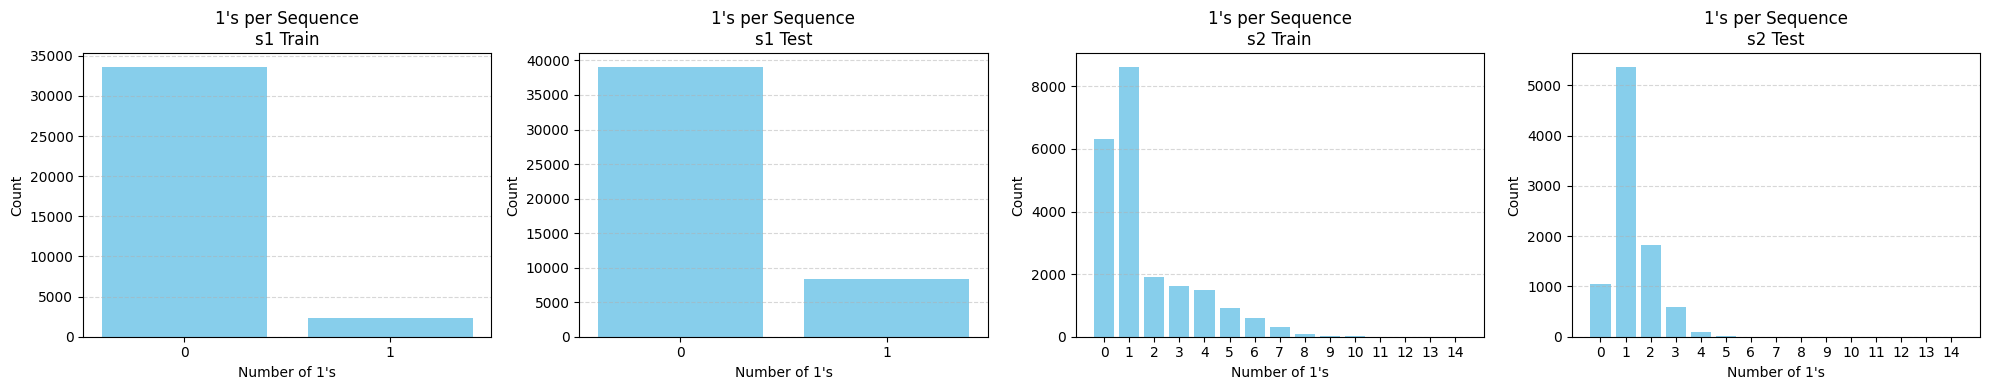

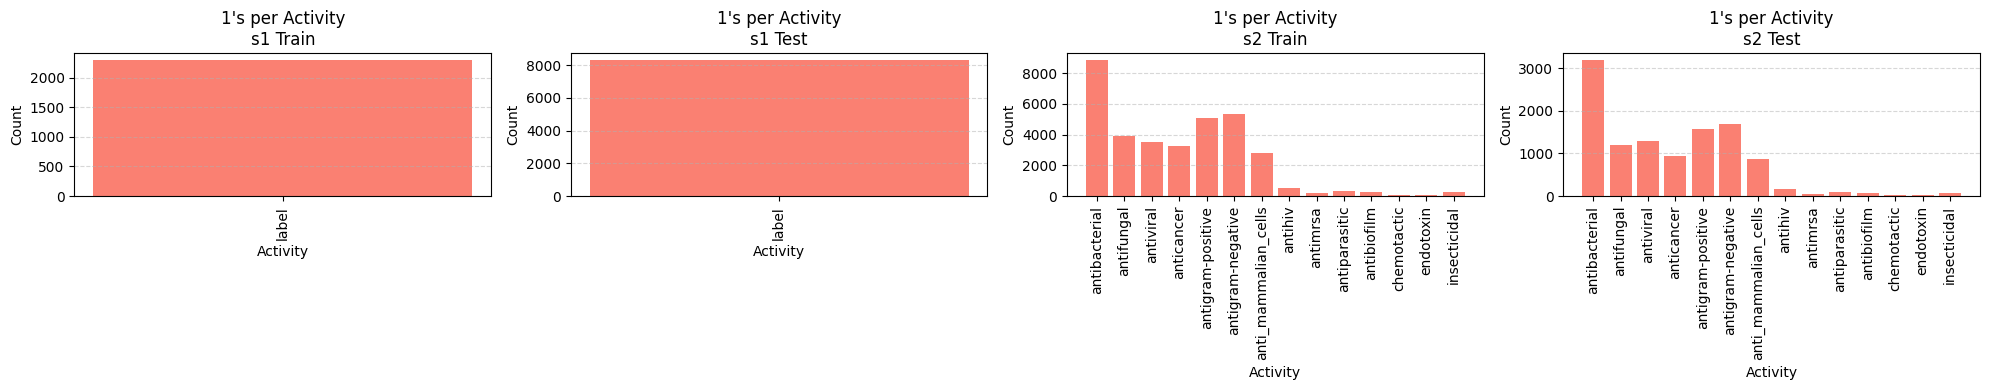

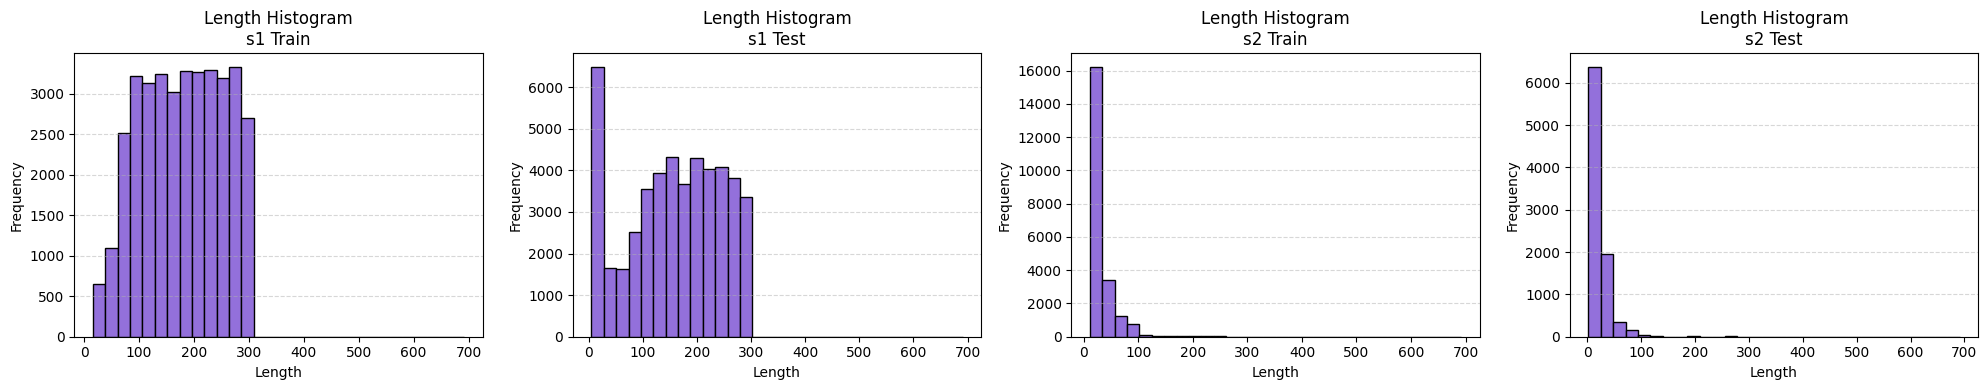

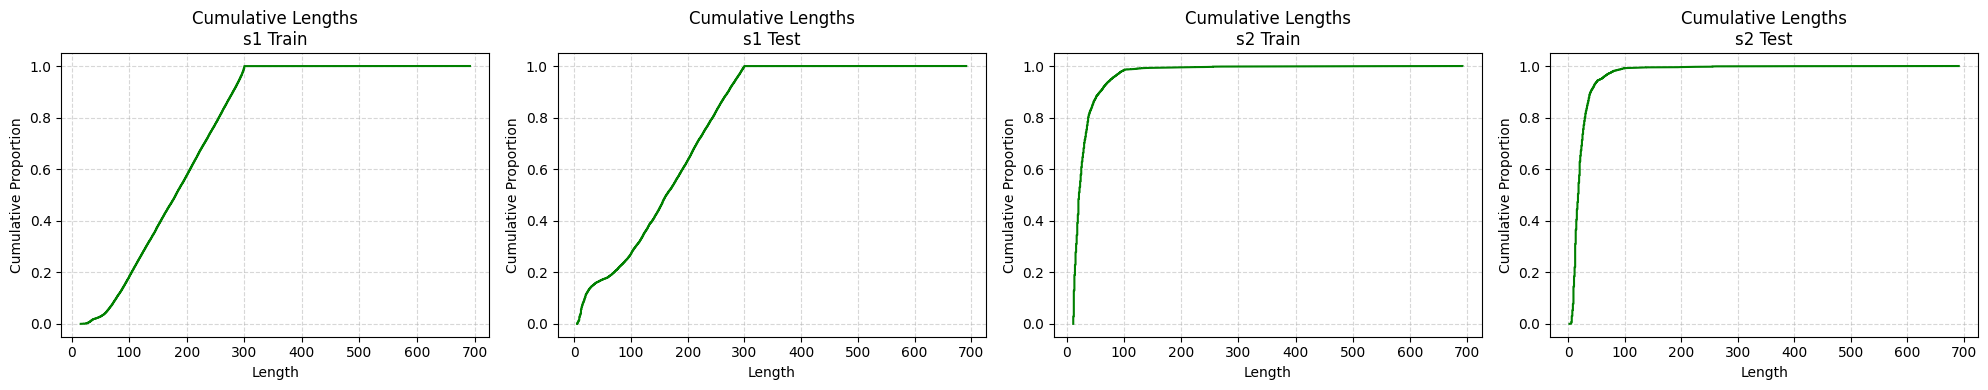

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_amp_statistics_multiple(csv_paths, labels=None):
    if labels is None:
        labels = [f'Dataset {i+1}' for i in range(len(csv_paths))]

    all_count_dicts = []
    all_activity_counts = []
    all_sequence_lengths = []

    for path in csv_paths:
        df = pd.read_csv(path)
        activity_columns = df.columns[2:]

        count_dict = {i: 0 for i in range(len(activity_columns) + 1)}
        activity_count = {col: 0 for col in activity_columns}
        sequence_lengths = []

        for _, row in df.iterrows():
            num_ones = row[activity_columns].sum()
            count_dict[num_ones] += 1
            for col in activity_columns:
                activity_count[col] += row[col]
            sequence_lengths.append(len(row['sequence']))

        all_count_dicts.append(count_dict)
        all_activity_counts.append(activity_count)
        all_sequence_lengths.append(sequence_lengths)

    num_files = len(csv_paths)
    figsize = (5 * num_files, 4)

    # --- Plot 1: Distribution of Number of 1's per Sequence ---
    plt.figure(figsize=figsize)
    for i, count_dict in enumerate(all_count_dicts):
        plt.subplot(1, num_files, i+1)
        plt.bar(count_dict.keys(), count_dict.values(), color='skyblue')
        plt.title(f"1's per Sequence\n{labels[i]}")
        plt.xlabel("Number of 1's")
        plt.ylabel("Count")
        plt.xticks(list(count_dict.keys()))
        plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # --- Plot 2: Count of 1's per Activity Column ---
    plt.figure(figsize=figsize)
    for i, activity_count in enumerate(all_activity_counts):
        plt.subplot(1, num_files, i+1)
        plt.bar(activity_count.keys(), activity_count.values(), color='salmon')
        plt.title(f"1's per Activity\n{labels[i]}")
        plt.xlabel("Activity")
        plt.ylabel("Count")
        plt.xticks(rotation=90)
        plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # --- Plot 3: Sequence Length Histogram ---
    plt.figure(figsize=figsize)
    for i, lengths in enumerate(all_sequence_lengths):
        plt.subplot(1, num_files, i+1)
        plt.hist(lengths, bins=30, color='mediumpurple', edgecolor='black')
        plt.title(f"Length Histogram\n{labels[i]}")
        plt.xlabel("Length")
        plt.ylabel("Frequency")
        plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # --- Plot 4: Cumulative Sequence Lengths ---
    plt.figure(figsize=figsize)
    for i, lengths in enumerate(all_sequence_lengths):
        sorted_lengths = np.sort(lengths)
        cumulative = np.arange(1, len(sorted_lengths)+1) / len(sorted_lengths)
        plt.subplot(1, num_files, i+1)
        plt.plot(sorted_lengths, cumulative, color='green')
        plt.title(f"Cumulative Lengths\n{labels[i]}")
        plt.xlabel("Length")
        plt.ylabel("Cumulative Proportion")
        plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

csv_paths = ['./data/s1_train_AMPseqs.csv', 
             './data/s1_test_AMPseqs.csv', 
            './data/s2_train_AMPseqs.csv', 
             './data/s2_test_AMPseqs.csv']

labels = ['s1 Train', 's1 Test', 's2 Train', 's2 Test']
plot_amp_statistics_multiple(csv_paths, labels)

In [ ]:
# fasta to csv for s1
import csv
from Bio import SeqIO

def get_sequences_from_fasta(fasta_file, used_ids, label):
    sequences = []
    with open(fasta_file, "r") as f:
        for record in SeqIO.parse(f, "fasta"):
            seq_id = str(record.id)
            original_id = seq_id
            suffix = 1
            # Ensure the ID is unique by checking if it's already used
            while seq_id in used_ids:
                seq_id = f"{original_id}X{suffix}"
                suffix += 1
            used_ids.add(seq_id)
            sequences.append((seq_id, str(record.seq), label))  # Include the label
    return sequences

def create_csv_for_sequences(non_amp_fasta, amp_fasta, output_csv):
    used_ids = set()  # To track used IDs and ensure they are unique
    all_sequences = []

    # Process the non-AMP sequences (label = 0)
    non_amp_sequences = get_sequences_from_fasta(non_amp_fasta, used_ids, label=0)
    all_sequences.extend(non_amp_sequences)

    # Process the AMP sequences (label = 1)
    amp_sequences = get_sequences_from_fasta(amp_fasta, used_ids, label=1)
    all_sequences.extend(amp_sequences)

    # Write the sequences and their labels to a CSV file
    with open(output_csv, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["id", "sequence", "label"])  # Write header
        writer.writerows(all_sequences)  # Write data rows

# Usage example
non_amp_fasta =  "/cluster/home/austinen/mini/ampmini/data/AMP_s1/test/test_nonAMPs.fasta" # "/cluster/home/austinen/mini/ampmini/data/AMP_s1/train/train_nonAMPs_cdhit_40.fasta"
amp_fasta = "/cluster/home/austinen/mini/ampmini/data/AMP_s1/test/test_AMPs.fasta" #"/cluster/home/austinen/mini/ampmini/data/AMP_s1/train/train_AMPs_cdhit_40.fasta"
output_csv = "/cluster/home/austinen/mini/ampmini/data/s1_test_AMPseqs.csv"

create_csv_for_sequences(non_amp_fasta, amp_fasta, output_csv)


In [18]:
import torch

# Create example tensors A, B, C, D with shape (B=2, C=2, T=3)
A = torch.tensor([[[1, 2, 3], [4, 5, 6]], [[7, 8, 9], [10, 11, 12]]], dtype=torch.float32)
B = torch.tensor([[[13, 14, 15], [16, 17, 18]], [[19, 20, 21], [22, 23, 24]]], dtype=torch.float32)
C = torch.tensor([[[25, 26, 27], [28, 29, 30]], [[31, 32, 33], [34, 35, 36]]], dtype=torch.float32)
D = torch.tensor([[[37, 38, 39], [40, 41, 42]], [[43, 44, 45], [46, 47, 48]]], dtype=torch.float32)

# Stack the tensors into one with shape (4, B, C, T)
# stacked = torch.stack([A, B, C, D], dim=0)     # shape: (4, 2, 2, 3)
# stacked = torch.cat((A, B, C, D), dim=0)         # shape: (4, 2, 2, 3)
# print(A.shape)
out = torch.cat((A[...,:1],B[...,:1],C[...,:1],D[...,:1]),dim=2)
for i in range(1,4):
    stacked = torch.cat((A[...,i:i+1],B[...,i:i+1],C[...,i:i+1],D[...,i:i+1]),dim=2)  # shape: (4, 2, 2, 3
    out = torch.cat((out,stacked),dim=2)  # shape: (4, 2, 2, 3)
interleaved = out.clone()      # shape: (2, 2, 12)
# 
# Print the result
print("Interleaved Tensor:\n", interleaved)
print("Interleaved Tensor shape:", interleaved.shape)
pool = torch.nn.MaxPool1d(kernel_size=4)  # Pooling layer with kernel size 4 and stride 4
# out = torch.tensor(interleaved,dtype=torch.float32)      # shape: (2, 2, 12)
out = pool(interleaved)                        # shape: (2, 2, 12)
print("Output shape after pooling:", out)
print("Output Tensor:\n", out.shape)



Interleaved Tensor:
 tensor([[[ 1., 13., 25., 37.,  2., 14., 26., 38.,  3., 15., 27., 39.],
         [ 4., 16., 28., 40.,  5., 17., 29., 41.,  6., 18., 30., 42.]],

        [[ 7., 19., 31., 43.,  8., 20., 32., 44.,  9., 21., 33., 45.],
         [10., 22., 34., 46., 11., 23., 35., 47., 12., 24., 36., 48.]]])
Interleaved Tensor shape: torch.Size([2, 2, 12])
Output shape after pooling: tensor([[[37., 38., 39.],
         [40., 41., 42.]],

        [[43., 44., 45.],
         [46., 47., 48.]]])
Output Tensor:
 torch.Size([2, 2, 3])


In [21]:
import torch

# Sample tensors for demonstration (shape: B x C x T = 2 x 2 x 4)
A = torch.tensor([[[1, 2, 3], [4, 5, 6]], [[7, 8, 9], [10, 11, 12]]], dtype=torch.float32)
B = torch.tensor([[[13, 14, 15], [16, 17, 18]], [[19, 20, 21], [22, 23, 24]]], dtype=torch.float32)
C = torch.tensor([[[25, 26, 27], [28, 29, 30]], [[31, 32, 33], [34, 35, 36]]], dtype=torch.float32)
D = torch.tensor([[[37, 38, 39], [40, 41, 42]], [[43, 44, 45], [46, 47, 48]]], dtype=torch.float32)

# Put tensors in a list
tensors = [A, B, C, D]

# Interleave across the last dimension
interleaved = torch.cat(
    [torch.cat([t[..., i:i+1] for t in tensors], dim=2) for i in range(A.shape[-1])],
    dim=2
)
pool = torch.nn.MaxPool1d(kernel_size=4) 
out = pool(interleaved) 

print("Interleaved shape:", interleaved.shape)
print("Interleaved tensor:\n", interleaved)
print("Output shape after pooling:", out.shape)
print("Output tensor:\n", out)


Interleaved shape: torch.Size([2, 2, 12])
Interleaved tensor:
 tensor([[[ 1., 13., 25., 37.,  2., 14., 26., 38.,  3., 15., 27., 39.],
         [ 4., 16., 28., 40.,  5., 17., 29., 41.,  6., 18., 30., 42.]],

        [[ 7., 19., 31., 43.,  8., 20., 32., 44.,  9., 21., 33., 45.],
         [10., 22., 34., 46., 11., 23., 35., 47., 12., 24., 36., 48.]]])
Output shape after pooling: torch.Size([2, 2, 3])
Output tensor:
 tensor([[[37., 38., 39.],
         [40., 41., 42.]],

        [[43., 44., 45.],
         [46., 47., 48.]]])


In [12]:
import torch

# Example tensors of shape (2, 3)
A = torch.tensor([[1, 2, 3], [4, 5, 6]])
B = torch.tensor([[7, 8, 9], [10, 11, 12]])

# Stack them vertically (along the 0th axis)
result = torch.vstack((A, B))
print(result.shape)

print(result)


torch.Size([4, 3])
tensor([[ 1,  2,  3],
        [ 4,  5,  6],
        [ 7,  8,  9],
        [10, 11, 12]])


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=3.0, dropout=0.1):
        super().__init__()
        self.cross_attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(dim)
        
        self.mlp = nn.Sequential(
            nn.Linear(dim, int(dim * mlp_ratio)),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(int(dim * mlp_ratio), dim),
            nn.Dropout(dropout)
        )
        self.norm2 = nn.LayerNorm(dim)

    def forward(self, x, context, context_mask=None):
        """
        x: (B, T_q, D) - query input
        context: (B, T_kv, D) - key/value input
        context_mask: (B, T_kv) - optional attention mask for context
        """
        # Cross-attention
        attn_out, _ = self.cross_attn(query=x, key=context, value=context, key_padding_mask=context_mask)
        x = x + attn_out
        x = self.norm1(x)

        # Feed-forward
        mlp_out = self.mlp(x)
        x = x + mlp_out
        x = self.norm2(x)

        return x

class TranCNN(nn.Module):

    def __init__(
        self, 
        d_input=[531,21,23,3],
        vocab_size=None, 
        seq_len=200,
        dropout=0.1,
        hid_dim=64,
        k_cnn=[2,3,4,5,6],
        d_output=24,
        k_size=2,
        depth = 4):
        super(TranCNN, self).__init__()
        
        self.batchnorm_4=nn.BatchNorm1d(num_features=d_input[3])
        self.convs_1 = nn.ModuleList([
                nn.Sequential(nn.Conv1d(in_channels=d_input[0], 
                                        out_channels=hid_dim, 
                                        kernel_size=h,padding = h//2),
                              nn.BatchNorm1d(num_features=hid_dim), 
                              nn.ReLU(),
                              nn.MaxPool1d(kernel_size=k_size))
                     for h in k_cnn
                    ])
        self.convs_2 = nn.ModuleList([
                nn.Sequential(nn.Conv1d(in_channels=d_input[1], 
                                        out_channels=hid_dim, 
                                        kernel_size=h,padding = h//2),
                              nn.BatchNorm1d(num_features=hid_dim), 
                              nn.ReLU(),
                              nn.MaxPool1d(kernel_size=k_size))
                     for h in k_cnn
                    ])
        self.convs_3 = nn.ModuleList([
                nn.Sequential(nn.Conv1d(in_channels=d_input[2], 
                                        out_channels=hid_dim, 
                                        kernel_size=h,padding = h//2),
                              nn.BatchNorm1d(num_features=hid_dim), 
                              nn.ReLU(),
                              nn.MaxPool1d(kernel_size=k_size))
                     for h in k_cnn
                    ])
        self.convs_4 = nn.ModuleList([
                nn.Sequential(nn.Conv1d(in_channels=d_input[3], 
                                        out_channels=hid_dim, 
                                        kernel_size=h,padding = h//2),
                              nn.BatchNorm1d(num_features=hid_dim), 
                              nn.ReLU(),
                              nn.MaxPool1d(kernel_size=k_size))
                     for h in k_cnn
                    ])
        
        self.maxpool_1=nn.MaxPool1d(kernel_size=len(k_cnn))
        self.maxpool_2=nn.MaxPool1d(kernel_size=len(k_cnn))
        self.maxpool_3=nn.MaxPool1d(kernel_size=len(k_cnn))
        self.maxpool_4=nn.MaxPool1d(kernel_size=len(k_cnn))

        self.conv = nn.Sequential(nn.Conv1d(in_channels=4*hid_dim, 
                                        out_channels=8*hid_dim, 
                                        kernel_size=3, 
                                        padding=1),
                                        nn.BatchNorm1d(num_features=8*hid_dim),
                                        nn.ReLU(),
                                        nn.MaxPool1d(kernel_size=2))
        
        self.middle = nn.ModuleList([MBlock(8*hid_dim, 8, mlp_ratio=3.0, dropout=dropout) for _ in range(depth)])
        self.drop = nn.Dropout(dropout)
        self.final = nn.ModuleList([
                nn.Sequential(nn.Conv1d(in_channels=8*hid_dim, 
                                        out_channels=8*hid_dim, 
                                        kernel_size=3,padding = k//2),
                              nn.BatchNorm1d(num_features=8*hid_dim), 
                              nn.ReLU(),
                              nn.MaxPool1d(kernel_size=k))
                     for k in [5,5,2]
                    ])
        
        self.fc = nn.Linear(8*hid_dim, d_output)
        self.sigmoid=nn.Sigmoid()



    def forward(self, AAI_feat,onehot_feat,BLOSUM62_feat,PAAC_feat):
        
        AAI_feat = AAI_feat.permute(0,2,1)
        out_1 = [conv(AAI_feat) for conv in self.convs_1] 
        onehot_feat = onehot_feat.permute(0,2,1)
        out_2 = [conv(onehot_feat) for conv in self.convs_2] 
        BLOSUM62_feat = BLOSUM62_feat.permute(0,2,1)
        out_3 = [conv(BLOSUM62_feat) for conv in self.convs_3] 
        PAAC_feat = PAAC_feat.permute(0,2,1)
        out_4 = [conv(PAAC_feat) for conv in self.convs_4] 
        

        out_1 = torch.cat(out_1, dim=2)
        out_1=self.maxpool_1(out_1)
        out_2 = torch.cat(out_2, dim=2)
        out_2=self.maxpool_2(out_2)
        out_3 = torch.cat(out_3, dim=2)
        out_3=self.maxpool_3(out_3)
        out_4 = torch.cat(out_4, dim=2)
        out_4=self.maxpool_4(out_4)
    
        x=torch.cat([out_1,out_2,out_3,out_4],dim=1)
        x = self.conv(x)
        x = x.permute(0,2,1)
        for mlayer in self.middle:
            x = mlayer(x, x)
        x = x.permute(0,2,1)
        for layer in self.final:
            x = layer(x)
        x = x.view(-1, x.size(1)) 
        x = self.fc(x)
        x = self.sigmoid(x)
        return x
    
# Example usage
AAI_feat = torch.randn(2, 200, 531)
onehot_feat = torch.randn(2, 200, 21)
BLOSUM62_feat = torch.randn(2, 200, 23)
PAAC_feat = torch.randn(2, 200, 3)
model = TranCNN()
output = model(AAI_feat, onehot_feat, BLOSUM62_feat, PAAC_feat)
print(output.shape) 


In [ ]:
import pandas as pd

# Load the CSV file into a DataFrame
csv_path = '/cluster/home/austinen/mini/ampmini/data/AMP_sequences.csv'  # Replace with your CSV file path
df = pd.read_csv(csv_path)

# Drop the 'id' and 'sequence' columns as we only need the activity columns
activity_columns = df.columns[2:]  # Assuming 'id' and 'sequence' are the first two columns

# Create a dictionary to store the count of sequences with specific number of 1's
count_dict = {i: 0 for i in range(len(activity_columns) + 1)}  # max number of 1's is the number of activity columns

# Create a dictionary to store the count of 1's in each activity column
activity_counts = {col: 0 for col in activity_columns}

# Iterate over each row in the DataFrame and count the 1's in the activity columns
for index, row in df.iterrows():
    # Count the number of 1's in the activity columns
    num_ones = row[activity_columns].sum()
    
    # Increment the count for this number of 1's
    count_dict[num_ones] += 1

    # Count the number of 1's in each activity column
    for col in activity_columns:
        activity_counts[col] += row[col]

# Print the counts of sequences with each number of 1's
print("Count of sequences with specific numbers of 1's:")
for num_ones, count in count_dict.items():
    print(f"Sequences with {num_ones} ones: {count}")

# Print the number of 1's in each individual activity column
print("\nCount of 1's in each activity column:")
for col, count in activity_counts.items():
    print(f"{col}: {count}")



In [ ]:
import pandas as pd

# Load the CSV file into a DataFrame
csv_path = '/cluster/home/austinen/mini/ampmini/data/AMP_sequences.csv'
df = pd.read_csv(csv_path)

# Drop the 'id' and 'sequence' columns to isolate activity columns
activity_columns = df.columns[2:]

# Calculate number of ones per row
df['num_ones'] = df[activity_columns].sum(axis=1)

# Filter out sequences with zero ones
filtered_df = df[df['num_ones'] > 0].drop(columns='num_ones')

# Save to new CSV
output_path = '/cluster/home/austinen/mini/ampmini/data/AMP_sequences_filtered.csv'
filtered_df.to_csv(output_path, index=False)

print(f"Filtered dataset saved to: {output_path}")
print(f"Original dataset size: {len(df)}, Filtered size: {len(filtered_df)}")


In [ ]:
from transformers import AutoTokenizer, EsmForProteinFolding

model = EsmForProteinFolding.from_pretrained("./esmfold_v1_local",local_files_only=True)
tokenizer = AutoTokenizer.from_pretrained("./esmfold_v1_local",local_files_only=True)
inputs = tokenizer(["MLKNVQVQLV","MLKNVQVQLV","MLKNVQVQLV","MLKNVQVQLV",], return_tensors="pt", add_special_tokens=False)  # A tiny random peptide
outputs = model(**inputs)
folded_positions = outputs.states
print(folded_positions.shape)
print(outputs.s_s.shape)
print(outputs.s_z.shape)

In [ ]:
import torch
from transformers import AutoTokenizer, EsmForProteinFolding

# Load model and tokenizer from local directory
model = EsmForProteinFolding.from_pretrained("./esmfold_v1_local", local_files_only=True)
tokenizer = AutoTokenizer.from_pretrained("./esmfold_v1_local", local_files_only=True)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()  # Turn off dropout

# Prepare input sequences
sequences = ["MLKNVQVQLV"] * 4  # Batch of 4 sequences

# Tokenize and move inputs to GPU
inputs = tokenizer(sequences, return_tensors="pt", add_special_tokens=False)
inputs = {k: v.to(device) for k, v in inputs.items()}

# Run model inference
with torch.no_grad():
    outputs = model(**inputs)

# Access outputs
folded_positions = outputs.states  # (B, L, D)
print("folded_positions:", folded_positions.shape)
print("s_s (per-residue embedding):", outputs.s_s.shape)   # (B, L, D)
print("s_z (pairwise features):", outputs.s_z.shape)       # (B, L, L, D)


In [ ]:
from transformers import AutoTokenizer, EsmForProteinFolding

model_name = "facebook/esmfold_v1"

# Download from Hugging Face and cache locally
model = EsmForProteinFolding.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Save locally to a directory
model.save_pretrained("./esmfold_v1_local")
tokenizer.save_pretrained("./esmfold_v1_local")


In [ ]:
from transformers import AutoTokenizer, EsmForProteinFolding
import torch

# Load the model and tokenizer
model = EsmForProteinFolding.from_pretrained("facebook/esmfold_v1")
tokenizer = AutoTokenizer.from_pretrained("facebook/esmfold_v1")

# Example protein sequence (single chain protein)
sequence = "GSTIQPGTGYNNGYFYSYWNDGHGGVTYTNGPGGQF"

# Tokenize the input sequence
inputs = tokenizer(sequence, return_tensors="pt")

# Define the number of recycles for inference (higher values yield better accuracy)
num_recycles = 4

# Run the model for structure prediction
with torch.no_grad():
    outputs = model(
        input_ids=inputs["input_ids"], 
        attention_mask=inputs["attention_mask"], 
        num_recycles=num_recycles,
    )

# Get the hidden states (feature maps) from the model
hidden_states = outputs.hidden_states  # This will be a tuple containing hidden states from each layer

# Extract the feature maps from the last hidden layer (or any intermediate layer)
# For example, using the last hidden state layer
last_hidden_states = hidden_states[-1]  # Shape: (batch_size, sequence_length, hidden_size)

# Example: You can also use intermediate hidden states, e.g., the 12th layer in ESM-2 model
intermediate_hidden_states = hidden_states[12]  # For example, using the 12th layer

# Now `last_hidden_states` or `intermediate_hidden_states` can be used as feature maps
# These feature maps can be used for cross-attention or any downstream tasks

# Example: Print the shape of the last hidden states
print("Shape of last hidden states (feature maps):", last_hidden_states.shape)  # (batch_size, sequence_length, hidden_size)

# Example: Print the feature map from the first token (representing the start of the sequence)
print("Feature map for the first token:", last_hidden_states[0, 0].tolist())  # The feature map for the first token


In [ ]:
import pandas as pd
from collections import Counter
from itertools import accumulate

# Load the CSV file
df = pd.read_csv("/cluster/home/austinen/mini/ampmini/data/AMP_sequences_filtered.csv")

# Compute sequence lengths
lengths = df["sequence"].dropna().apply(len)

# Count occurrences of each length
length_counts = Counter(lengths)

# Sort by length
length_counts = dict(sorted(length_counts.items()))

# Compute cumulative counts
cumulative_counts = list(accumulate(length_counts.values()))

# Print results
for (length, count), cum_count in zip(length_counts.items(), cumulative_counts):
    print(f"Length {length}: {count} sequences (Cumulative: {cum_count})")


In [ ]:
import pandas as pd
from collections import Counter
from itertools import accumulate
import matplotlib.pyplot as plt
import numpy as np

# Load the CSV file
df = pd.read_csv("/cluster/home/austinen/mini/ampmini/data/AMP_sequences_filtered.csv")

# Compute sequence lengths
lengths = df["sequence"].dropna().apply(len)

# Count occurrences of each length
length_counts = Counter(lengths)

# Sort by length
length_counts = dict(sorted(length_counts.items()))

# Compute cumulative counts
cumulative_counts = list(accumulate(length_counts.values()))

# Print results
# for (length, count), cum_count in zip(length_counts.items(), cumulative_counts):
#     print(f"Length {length}: {count} sequences (Cumulative: {cum_count})")

# Prepare data for plotting
length_keys = list(length_counts.keys())
counts = list(length_counts.values())

# Plot histogram (bar plot)
plt.figure(figsize=(10, 5))
plt.bar(length_keys, counts, color='skyblue')
plt.xlabel("Sequence Length")
plt.ylabel("Count")
plt.title("Histogram of Sequence Lengths")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# Plot cumulative count (line plot)
plt.figure(figsize=(10, 5))
plt.plot(length_keys, cumulative_counts, color='crimson', marker='o')
plt.xlabel("Sequence Length")
plt.ylabel("Cumulative Count")
plt.title("Cumulative Count of Sequence Lengths")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# Compute statistics
mean_count = np.mean(counts)
var_count = np.var(counts)

print(f"\nMean of counts: {mean_count:.2f}")
print(f"Variance of counts: {var_count:.2f}")
